
# Object Detection with Yolo v3

The [*You Only Look Once* detector (YOLO)](https://pjreddie.com/darknet/yolo/) is a real-time object detection system based on CNNs.  It is extremely fast - over 100x faster than Fast-RCNN.

It applies a single neural network to the full image, dividing the image into regions and jointly predicts bounding boxes and probabilities for each region. These bounding boxes are weighted by the predicted probabilities.

![YOLO v3](https://pjreddie.com/media/image/yologo_2.png)

## qqwweee implementation of YOLOv3
This lab is based on the following implementation of Yolo in Keras - https://github.com/qqwweee/keras-yolo3.

We'll clone the Mask R-CNN code directly from the GitHub repository.
If we have run this step already, you'll see an error of the form fatal: destination path 'Mask_RCNN' already exists and is not an empty directory which you can safely ignore.

In [1]:
!git clone https://github.com/qqwweee/keras-yolo3.git

fatal: destination path 'keras-yolo3' already exists and is not an empty directory.


First, we'll load TensorFlow v1.x, as required by this YOLOv3 model.

In [0]:
%tensorflow_version 1.x
import tensorflow as tf

*To* ensure these labs run as fast as possible, from the menu above select **Edit > Notebook settings or Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU.

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

And now we can load Keras and the rest of the Python libraries we need into our notebook runtime.

In [4]:
import os
import sys
import numpy as np

from keras import backend as K
from keras.models import load_model
from keras.layers import Input

ROOT_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(ROOT_DIR)

from yolo3.utils import *
from yolo3.model import *

# And various libraries for image manipulation and plotting
import random
import cv2
from PIL import Image
import urllib
import matplotlib.patches as patches
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Converting pre-trained weights

We can leverage some weights that are pre-trained from the the YOLO website - https://pjreddie.com/darknet/yolo/. YOLO is originally developed in an open source neural network framework called Darknet, so we needt o convert the weights from the Darknet format into the HDF5 format that TensorFlow/Keras can read.

Our pre-trained model is trained on the Microsoft COCO dataset. ![COCO Examples](http://cocodataset.org/images/coco-examples.jpg)

COCO has several features:

* Object segmentation;
* Recognition in context;
* Superpixel stuff segmentation;
* 330K images (>200K labeled);
* 1.5 million object instances;
* 80 object categories;
* 91 stuff categories;
* 5 captions per imag
* 250,000 people with keypoints.

You can read more about COCO at http://cocodataset.org/#home

HDF5 (.h5, .hdf5) is a file format suitable for storing large multidimensional numeric arrays (e.g. models, data files). HDF stands for Hierarchical Data Format, and can store everything about your model, including:

* The architecture of the model;
* The weights of the model;
* The training configuration (loss, optimizer);
* The state of the optimizer, so you can resume training exactly where you left off.

You can read more about the HDF5 file format at http://docs.h5py.org/en/stable/quick.html, and at the Keras API for loading and saving models at https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model


The weights are about 240MB to download. The conversion will take a minute.

**Note:** As the model we are leveraging uses Tensorflow 1.x, you can safely ignore some warnings about deprecated functions.

In [5]:
!wget https://pjreddie.com/media/files/yolov3.weights -O keras-yolo3/yolov3.weights
!python keras-yolo3/convert.py keras-yolo3/yolov3.cfg keras-yolo3/yolov3.weights keras-yolo3/model_data/yolo.h5

--2019-11-23 18:57:31--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘keras-yolo3/yolov3.weights’

keras-yolo3/yolov3. 100%[===================>] 236.52M  62.8MB/s    in 4.1s    

2019-11-23 18:57:35 (57.7 MB/s) - ‘keras-yolo3/yolov3.weights’ saved [248007048/248007048]

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.


Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)




2019-11-23 18:57:39.535645: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-11-23 18:57:39.535964: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1f30bc0 initialized for platform Host (this does not guarantee t

Next, we need to setup a class_names array for our class detections, and a set of anchors.

The YOLO model returns a class index to represent the class, but we need the array to convert from the index number into a human readable string. These are just the standard 80 classes from COCO.

YOLO also uses anchor boxes - based on the intuition that most bounding boxes have common width to height ratios. Instead of predicting bounding boxes directly, YOLO works of a predetermined set of box sizes, called anchor boxes.



In [0]:
# We need to load our COCO class names
class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

# YOLO uses anchor boxes - setup our array of common width/heights
anchors = np.array([[ 10,  13],
       [ 16,  30],
       [ 33,  23],
       [ 30,  61],
       [ 62,  45],
       [ 59, 119],
       [116,  90],
       [156, 198],
       [373, 326]])
anchors = np.divide(anchors, 1.0) # convert our int array to float

Next, we'll build our YOLO model.  This uses the TensorFlow 1.x *session*-style API semantics.  You don't need to worry too much about this, as the TF2.x Keras style API is much nicer.

**Note:** As the model we are leveraging uses Tensorflow 1.x, you can safely ignore some warnings about deprecated functions.

In [7]:
num_classes = len(class_names)

# Set the expected image size for the model - the model expects an image size 
# where both the width and height are multiples of 32
model_image_size = (416, 416)
assert model_image_size[0]%32 == 0, 'Multiples of 32 required'
assert model_image_size[1]%32 == 0, 'Multiples of 32 required'

# Create YOLO model
model_path = os.path.join(ROOT_DIR, "model_data/yolo.h5")
yolo_model = load_model(model_path, compile=False)

# Disable warnings about deprecated TF 1.x functions vis-a-vis TF 2.x API
try:
    from tensorflow.python.util import module_wrapper as deprecation
except ImportError:
    from tensorflow.python.util import deprecation_wrapper as deprecation
deprecation._PER_MODULE_WARNING_LIMIT = 0

# Generate output tensor targets for bounding box predictions
# 
# Predictions for individual objects are based on a probability score 
# threshold of 0.3, and an IoU threshold for non-max suppression of 0.45
#
# When run, this will evaluate the YOLO model on given inputs, and return
# filtered bounding boxes to us

input_image_shape = K.placeholder(shape=(2, ))
boxes, scores, classes = yolo_eval(yolo_model.output, anchors, num_classes, 
                                   input_image_shape, score_threshold=0.3,
                                   iou_threshold=0.45)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


We'll create a helper function to detect objects in our image.

In [0]:
def detect_objects_in_image(image):
    # we convert out image data to 32-bit float, normalise it (between 0.0 and 0.1)
    image_data = np.array(image, dtype='float32')
    image_data /= 255.
    image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

    # Predict classes and locations using Tensorflow session
    sess = K.get_session()
    out_boxes, out_scores, out_classes = sess.run(
                [boxes, scores, classes],
                feed_dict={
                    yolo_model.input: image_data,
                    input_image_shape: [image.size[1], image.size[0]],
                    K.learning_phase(): 0
                })
    return out_boxes, out_scores, out_classes


And finally, a helper function to draw bounding boxes and labels on our original images and display them, so that we can see the results of our inference.

In [0]:
def draw_detected_objects_in_image(image, out_boxes, out_scores, out_classes):
    # Set up some display formatting
    cmap = plt.get_cmap('tab20b') # select a dark qualitative colormap for labels/bounding boxes
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    # Plot the image
    img = np.array(image)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    # Use a random color for each class
    unique_labels = np.unique(out_classes)
    n_cls_preds = len(unique_labels)
    bbox_colors = random.sample(colors, n_cls_preds)

    # process each instance of each class that was found
    for instance, class_index in reversed(list(enumerate(out_classes))):
        predicted_class = class_names[class_index]
        bbox = out_boxes[instance]
        score = out_scores[instance]


        # Unpack the bounding box coordinates
        (y1, x1, y2, x2) = bbox

        # Set the box dimensions
        box_h = (y2 - y1) 
        box_w = (x2 - x1)
        
        # Add a box with the color for this class
        color = bbox_colors[int(np.where(unique_labels == class_index)[0])]
        bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=4, edgecolor=color, facecolor='none')
        ax.add_patch(bbox)
        
        # Format the label to be added to the image for this instance and add it
        label = 'Class: {}, Score: {:.2f}'.format(predicted_class, score)
        plt.text(x1, y1, s=label, color='white', verticalalignment='top',
                bbox={'color': color, 'pad': 0})
        
    plt.axis('off')
    plt.show()


Okay, we now have enough boilerplate code written to grab a number of test images, and run them through our model to see how we get on.

For the sake of simplicity, we're cheating hugely here as we're just using sample images that are taken from the COCO dataset (so our model has already been exposed to them during training, and would be expected to do really well on them), but feel free to pick other image URLs and add them to the array below to run them through YOLO.

What is so impressive about deep convolutional classifiers and detectors is that, once they are fed with sufficient training data, they are unfazed by occlusions (where part of the object is hidden or obscured from view) or pose.

Considering image https://farm5.staticflickr.com/4088/5019078259_f4f91288f2_z.jpg
	Resizing (with letterbox) from  (639, 426)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

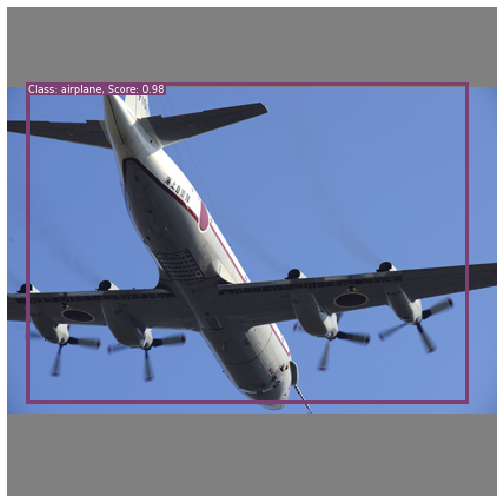

Considering image http://farm2.staticflickr.com/1419/4598390017_b554e5d29b_z.jpg
	Resizing (with letterbox) from  (640, 425)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

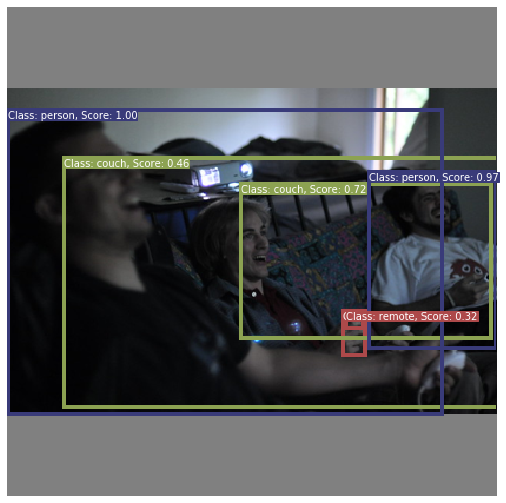

Considering image http://farm4.staticflickr.com/3329/3579898625_3d8a83c40c_z.jpg
	Resizing (with letterbox) from  (640, 427)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

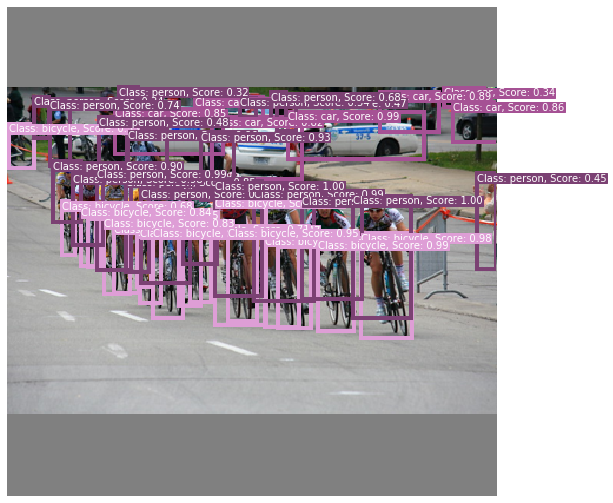

Considering image https://farm8.staticflickr.com/7331/9280720567_b684d5cccf_z.jpg
	Resizing (with letterbox) from  (639, 435)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

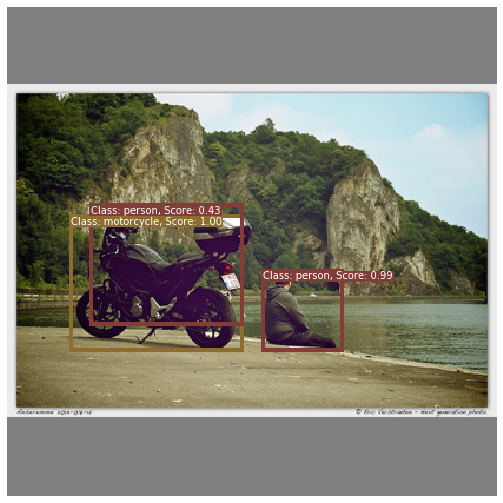

Considering image http://farm4.staticflickr.com/3175/2961808668_1d557e34a0_z.jpg
	Resizing (with letterbox) from  (640, 480)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

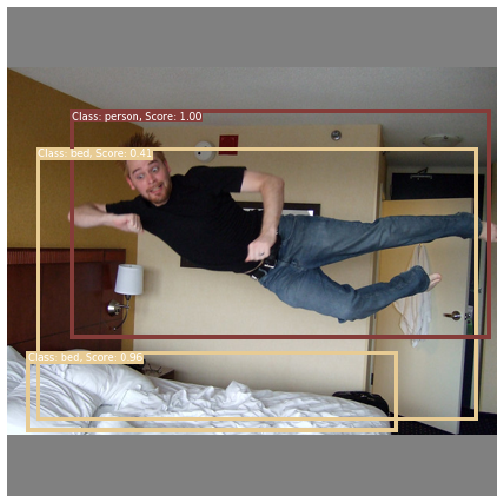

Considering image http://farm3.staticflickr.com/2441/3541164845_6fbea2e89f_z.jpg
	Resizing (with letterbox) from  (640, 429)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

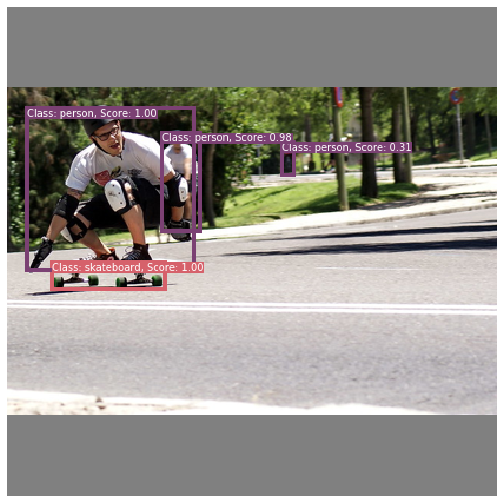

Considering image http://farm8.staticflickr.com/7296/9019745657_c8776db96f_z.jpg
	Resizing (with letterbox) from  (640, 480)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

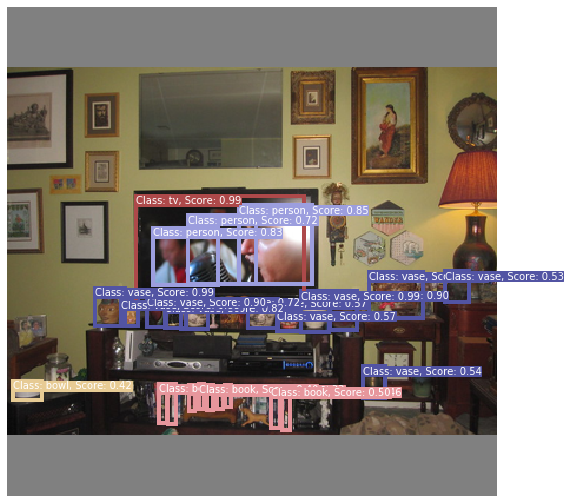

Considering image http://farm8.staticflickr.com/7108/6901315528_676d32186e_z.jpg
	Resizing (with letterbox) from  (640, 478)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

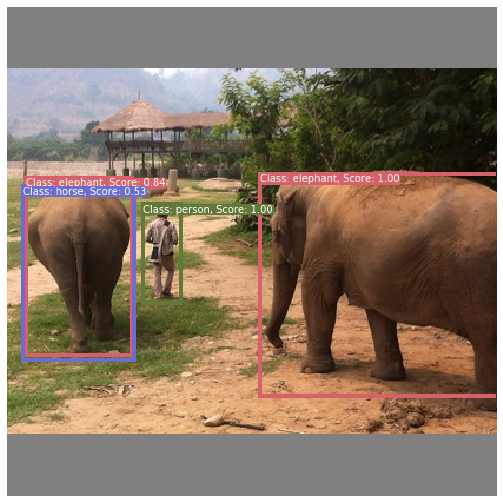

Considering image http://farm9.staticflickr.com/8101/8514154431_b8f1b57dc9_z.jpg
	Resizing (with letterbox) from  (640, 424)  to  (416, 416)


<Figure size 432x288 with 0 Axes>

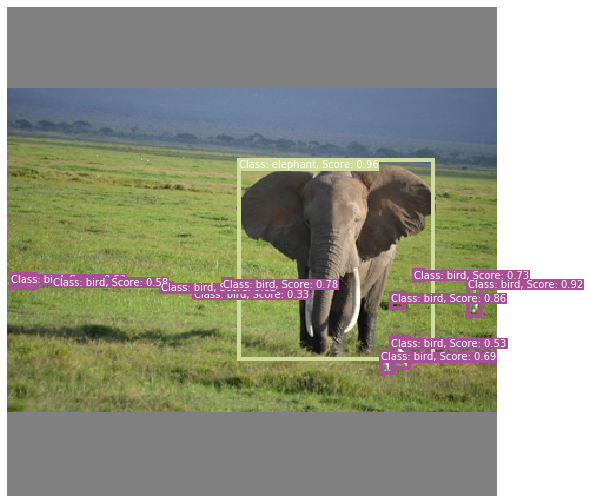

In [13]:
def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	pil_image = Image.fromarray(temp_image)
	return pil_image

image_urls = ["https://farm5.staticflickr.com/4088/5019078259_f4f91288f2_z.jpg", 
              "http://farm2.staticflickr.com/1419/4598390017_b554e5d29b_z.jpg", 
              "http://farm4.staticflickr.com/3329/3579898625_3d8a83c40c_z.jpg",
              "https://farm8.staticflickr.com/7331/9280720567_b684d5cccf_z.jpg",
              "http://farm4.staticflickr.com/3175/2961808668_1d557e34a0_z.jpg",
              "http://farm3.staticflickr.com/2441/3541164845_6fbea2e89f_z.jpg",
              "http://farm8.staticflickr.com/7296/9019745657_c8776db96f_z.jpg",
              "http://farm8.staticflickr.com/7108/6901315528_676d32186e_z.jpg",
              "http://farm9.staticflickr.com/8101/8514154431_b8f1b57dc9_z.jpg"
              ]

for image_url in image_urls:
  print("Considering image", image_url)
  image = url_to_image(image_url)
  
  if (image.size != model_image_size):
    print("\tResizing (with letterbox) from ", image.size, " to ", model_image_size)
    image = letterbox_image(image, tuple(reversed(model_image_size)))

  out_boxes, out_scores, out_classes = detect_objects_in_image(image)
  draw_detected_objects_in_image(image, out_boxes, out_scores, out_classes)

**Exercise:** Look for more image URLs via the COCO image explorer http://cocodataset.org/#explore or use Google.  Then paste the URLs into the test array `image_urls` in the cell above, and re-run the detections.